### Análise Exporatória dos dados

#### Contexto
Empresas de cartão de crédito precisam identificar transações fraudulentas para evitar cobranças indevidas.

#### Conteúdo
O conjunto de dados contém transações de cartões de crédito feitas por portadores europeus em setembro de 2013. Ele inclui 492 fraudes de um total de 284.807 transações, sendo que as fraudes representam 0,172% das transações. As variáveis de entrada são numéricas e resultam de uma transformação PCA, com exceção dos recursos 'Time' (tempo em segundos desde a primeira transação) e 'Amount' (valor da transação). A variável 'Class' indica se a transação é fraudulenta (1) ou não (0). Devido ao desequilíbrio de classes, recomenda-se usar a Área Sob a Curva de Precisão-Recall (AUPRC) para avaliar a precisão, em vez da matriz de confusão.

#### Importanto dados do Kaggle

Nessa parte estamos fazendo o download do conjunto de dados para realização das análises. O arquivo que contém do conjunto de dados se chama creditcard.csv. Também aproveitamos e o adionamos em um dataframe para fazer uma análise exploratória mais aprofundadada.

In [4]:
import kagglehub as kag 
import pandas as pd

In [5]:
path = kag.dataset_download("mlg-ulb/creditcardfraud")

In [6]:
file_csv = f"{path}/creditcard.csv"

#### Quais variáveis e sua quantidade?
Nesse ponto verfficamos que o conjunto total tem 31 variáveis sendo que três delas temos conhecimentos que são a (Time - tempo em segundo dese a primeira transação), (Amount - valor da transação) e a (Class - classes da obseração sendo [0 - não fraude] e [1 - fraude]). As variáveis de V1 até V28, como no enunciado dos dados, são componentes de um PCA que foi apliado nos dados antes do mesmo ser disponibilizado.

In [7]:
df = pd.read_csv(file_csv)

In [8]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [9]:
df.columns.shape[0]

31

#### Verificando o desbalanceamento dos dados
Ao verificarmos o nível de desbalanceamento percebemoa que existem 284315 observações que representam transações to tipo não fraude e 492 transações do tipo fraude. Em termos metemáticos temos uma diferença de quantidade entre as classes de 283823 pró classes não fraude. Resumindo, temos um conjunto de dados muito desbalanceado, onde a parte de classes fraudes não é representativa, perante a classe não fraude.

In [10]:
df_count_class = pd.DataFrame(df.Class.value_counts().reset_index())
df_count_class.columns = ['Classes', 'Frequência']
df_count_class

,Classes,Frequência
0,0,284315
1,1,492


#### Verificando a distribuição das classes fraudes e e não fraudes

Visualizando as distribuições das classes fraude e não fraude

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

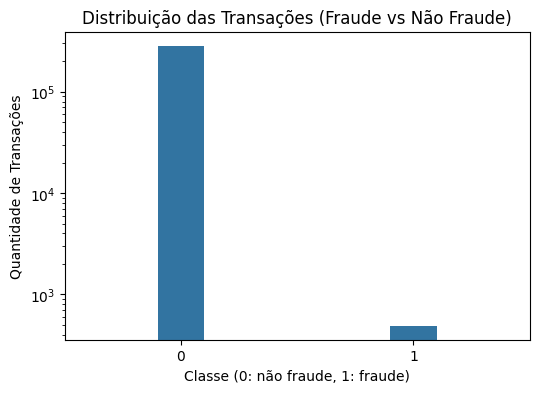

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df, width=0.2)
plt.title('Distribuição das Transações (Fraude vs Não Fraude)')
plt.xlabel('Classe (0: não fraude, 1: fraude)')
plt.ylabel('Quantidade de Transações')
plt.yscale('log')
plt.show()

#### Verificando a proporção entre classes fraude e não fraude
Verificando a proporção de fraudes, vemos que o desbalanceamento é muito significativo de aproximdamantente 0.173%

In [13]:
fraud_ratio = df[df.Class == 1].shape[0]/df[df.Class == 0].shape[0]
print(f'Proporção de fraudes: {fraud_ratio:.5f}')

Proporção de fraudes: 0.00173


#### Verificar a distribuição do valor das transações ('Amount') para fraudes e não fraudes
Interpretando os boxplots, obseravamos temos que a colune 'Amount' tem uma distribuição com simentria para cada classse visto que as medianas(segundo quartil) estão mais localizadas no centro das caixas. Observamos também valores discrepantes (outliers) acima do limite superior de detecção para ambas as classes. 

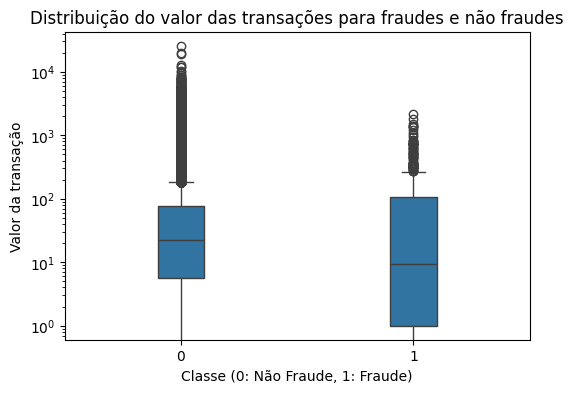

In [14]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Class', y='Amount', data=df, width=0.2)
plt.title('Distribuição do valor das transações para fraudes e não fraudes')
plt.xlabel('Classe (0: Não Fraude, 1: Fraude)')
plt.ylabel('Valor da transação')
plt.yscale('log')
plt.show()

#### Identificando quantas observações na coluna ('Amount') de cada uma das classes fraudes e não fraudes são outliers

In [15]:
# Calculando os quartis e o IQR para a coluna 'Amount'
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1

# Definindo os limites superior e inferior para identificar outliers
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Identificando outliers para as fraudes
outliers_fraude = df[(df['Class'] == 1) & ((df['Amount'] < lower_limit) | (df['Amount'] > upper_limit))]

# Identificando outliers para as transações não fraudulentas
outliers_nao_fraude = df[(df['Class'] == 0) & ((df['Amount'] < lower_limit) | (df['Amount'] > upper_limit))]

# Exibindo os outliers encontrados
print(f"Outliers nas transações fraudulentas: {outliers_fraude.shape[0]}")
print(f"Outliers nas transações não fraudulentas: {outliers_nao_fraude.shape[0]}")

Outliers nas transações fraudulentas: 91
Outliers nas transações não fraudulentas: 31813


#### Distribuição do valor das transações nas classes fraudes e não fraudes em transações atípicas (outliers)

Analisando a distribuição abaixo, percebemos que nas transações atípicas fraudulentas, os fraudadores sempre fazem transações com valores mais baixo, no intervalo de 0 a 2500 unidades. Nas transações legítimas é um pouco misturado com transações atípicas sendo altas e baixas. O que podemos tirar de insigths é que os fraudadores, para não chamarem a atenção, optam por fazer transações sendo repetidas ou não de valores baixos de forma frequente.

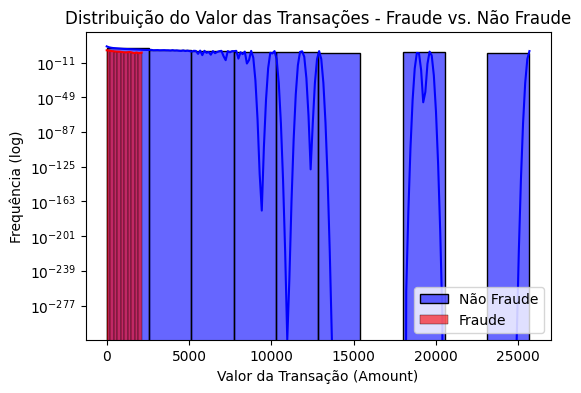

In [16]:
plt.figure(figsize=(6, 4))
sns.histplot(df[df['Class'] == 0]['Amount'], bins=10, color='blue', alpha=0.6, label='Não Fraude', kde=True)
sns.histplot(df[df['Class'] == 1]['Amount'], bins=10, color='red', alpha=0.6, label='Fraude', kde=True)
plt.yscale('log')
plt.xlabel('Valor da Transação (Amount)')
plt.ylabel('Frequência (log)')
plt.title('Distribuição do Valor das Transações - Fraude vs. Não Fraude')
plt.legend()
plt.show()

##### Analisando a plotagem abaixo podemos tirar algumas conclusões: 

-A mediana de todas as transações classificadas como fraude tende a ter mais valores baixos.

-A caixa IQR das transações fraudulentas é maior do que as não fraudulentas. Isso significa que há uma maior taxa de variação nas transações fraudulentas.

-A calda da caixa IQR fraudulenta é mais alta que a não fraudulenta. Isso significa que embora as transações fraudulentas sejam quase sempre de valores baixos, pode ocorrer em situações atípicas com valores altos.

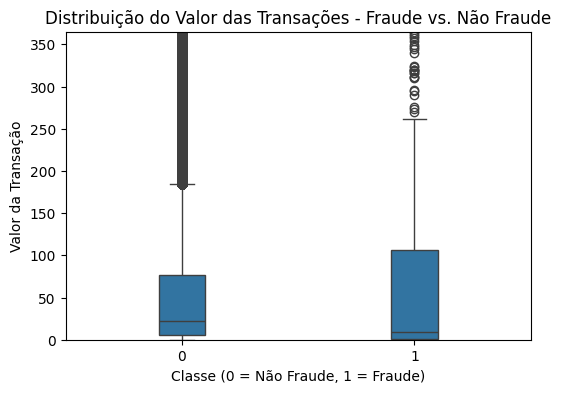

In [17]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['Class'], y=df['Amount'], width=0.2)
plt.ylim(0, df['Amount'].quantile(0.95))  # Limita o eixo Y para remover valores muito altos e facilitar a visualização
plt.title('Distribuição do Valor das Transações - Fraude vs. Não Fraude')
plt.xlabel('Classe (0 = Não Fraude, 1 = Fraude)')
plt.ylabel('Valor da Transação')
plt.show()

#### Verificar quantas fraudes ocorreram em valores realmente mais altos

Interpretando o resultado do código abaixo, observamos que realmente a maioria das fraudes ocorrem em transações de valores mais baixos, enquanto as transações não fraudulentas são bem distribuídas entre valores baixos e altos. Ou seja, de 100% da transações fraudulentas apenas 8,73% são de valores acima do limite do percentil 95. Isso apenas reforça que os fraudadores ao escolher entre realizar uma transação fraudulenta com0 valores altos ou baixos, ele vai tender na maioria das vezes realizar com valores baixos para não levantar suspeitas em esporadicas vezes valores altos quando ele quer dar um golpe mais arriscado, porém com grandes possibilidades de ter um lucro maior.

In [18]:
import numpy as np

# Definir o limite de valores altos (ex: 95º percentil das transações)
limite_alto = np.percentile(df['Amount'], 95)

# Contar fraudes acima do limite
fraudes_altas = df[(df['Class'] == 1) & (df['Amount'] > limite_alto)]
nao_fraudes_altas = df[(df['Class'] == 0) & (df['Amount'] > limite_alto)]

print(f"Total de fraudes acima do percentil 95: {len(fraudes_altas)}")
print(f"Total de transações não fraudulentas acima do percentil 95: {len(nao_fraudes_altas)}")

Total de fraudes acima do percentil 95: 43
Total de transações não fraudulentas acima do percentil 95: 14189


#### Comparando médias dos valores das transações fraudulentas e não fraudulentas

Como podemos ver no caso da média, vemos que a média de valores das transações fraudulentas são maiores que as da não fraudulentas. Como vimos anteriormente que para maioria das transações fraudulentas as transações eram de valores mais baixos, o valor das transações pode ser um fator relevante para identificar fraudes, porém ele não pode ser utilizado como único critério. Vamos analisar mais pra frente como essa informação se comporta através do calculo da mediana.

In [19]:
# Calcular a média de Amount para fraudes e não fraudes
media_fraude = df[df['Class'] == 1]['Amount'].mean()
media_nao_fraude = df[df['Class'] == 0]['Amount'].mean()

print(f'Média de Amount para fraudes: {media_fraude:.2f}')
print(f'Média de Amount para não fraudes: {media_nao_fraude:.2f}')

Média de Amount para fraudes: 122.21
Média de Amount para não fraudes: 88.29


#### Comparando medianas dos valores das transações fraudulentas e não fraudulentas

Agora ficou interessante! Vemos que o comportamento da mediana afirma o que estávamos falando acima, que a maioria das transações fraudulentes tem valores baixos. O cáculo da média acima mostrou o contrário justamente pq como tem algumas transações fraudulentas com valores altos, esses valores acabaram puxando a média pra cima. 

In [20]:
# Calcular a mediana de Amount para fraudes e não fraudes
media_fraude = df[df['Class'] == 1]['Amount'].median()
media_nao_fraude = df[df['Class'] == 0]['Amount'].median()

print(f'Mediana de Amount para fraudes: {media_fraude:.2f}')
print(f'Mediana de Amount para não fraudes: {media_nao_fraude:.2f}')

Mediana de Amount para fraudes: 9.25
Mediana de Amount para não fraudes: 22.00


#### Analisando a dispersão dos valores das transações fraudulentas e não fraudulentas

Analisando o plot abaixo, vemos que existem mais pontos densos nas transações não fraudulentas do que nas fraudulentas.Como há mais transações não fraudulentas os valores dessas transações acabam se espalhando por toda faixa de valores. Menos pontos e menos densidade nas transações fraudulentas. Isso significa que as fraudes seguem um padrão mais específico de valores, ou seja, confirma o que a gente vem falando sobre valores baixos na maioria das transaçaões fraudulentas.

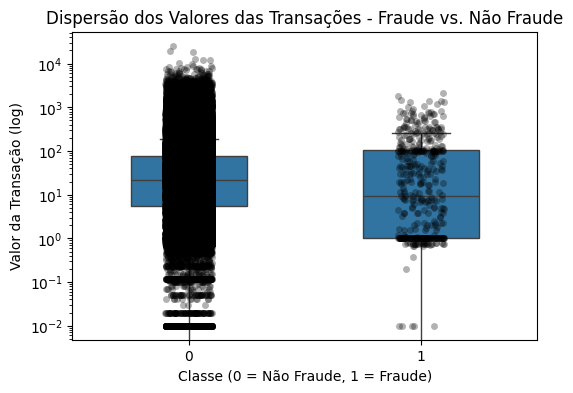

In [21]:
plt.figure(figsize=(6, 4))

# Criando o boxplot + stripplot para visualizar melhor os outliers
sns.boxplot(x='Class', y='Amount', data=df, showfliers=False, width=0.5)
sns.stripplot(x='Class', y='Amount', data=df, jitter=True, alpha=0.3, color='black')

plt.yscale('log')  # Escala logarítmica para melhor visualização
plt.xlabel('Classe (0 = Não Fraude, 1 = Fraude)')
plt.ylabel('Valor da Transação (log)')
plt.title('Dispersão dos Valores das Transações - Fraude vs. Não Fraude')

plt.show()

#### Verificando se há uma correlação linear forte entre as variáveis dependentes e a váriável classe

Analisando a correlação abaixo, vemos que não existe nenhuma variável com correlação forte com a variável classe, ou seja, apenas apresentam correlações baixas. Isso significa que o modelo de regressão logística, apesar de ser um modelo que pode funcionar para um problema dessa natureza (binário), ele pode não conseguir aprender bem sobre como identificas as fraudes justamente pq não existe uma correlação linear forte com as variáveis dependentes e independentes. Diante desse cenário, iremos utilizar além da (Regressão Logística), modelos como (XGBoost) e (RandomForest) visto que esses dois ultimos podem se adaptar melhor a esse conjunto de dados para capturar com mais eficácia as fraudes.

In [37]:
# Verifique a correlação entre as variáveis independentes e a variável dependente
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

# Ajustando a largura da tabela
corr.style.set_table_attributes('style="width: 70%;"').background_gradient(cmap='coolwarm', axis=None)

# Ajustando o tamanho da fonte e outras configurações
corr.style.set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '10px')]},  # Tamanho da fonte das colunas
     {'selector': 'td', 'props': [('font-size', '9px')]}   # Tamanho da fonte das células
]).background_gradient(cmap='coolwarm', axis=None)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,0.117396,-0.010593,-0.419618,-0.105260,0.173072,-0.063016,0.084714,-0.036949,-0.008660,0.030617,-0.247689,0.124348,-0.065902,-0.098757,-0.183453,0.011903,-0.073297,0.090438,0.028975,-0.050866,0.044736,0.144059,0.051142,-0.016182,-0.233083,-0.041407,-0.005135,-0.009413,-0.010596,-0.012323
V1,0.117396,1.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.227709,-0.101347
V2,-0.010593,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.531409,0.091289
V3,-0.419618,-0.000000,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.210880,-0.192961
V4,-0.105260,-0.000000,-0.000000,0.000000,1.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.098732,0.133447
V5,0.173072,0.000000,0.000000,-0.000000,-0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.386356,-0.094974
V6,-0.063016,-0.000000,0.000000,0.000000,-0.000000,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.215981,-0.043643
V7,0.084714,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.397311,-0.187257
V8,-0.036949,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.103079,0.019875
V9,-0.008660,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.044246,-0.097733


### Preparação dos dados para o modelo

#### Verificando a existência de dados faltantes

É verificado que o conjunto de dados não possui dados faltantes

In [27]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

#### Verificando se existem variáveis categóricas

O conjunto de dados não possui nenhum atributo do tipo categórico

In [31]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

#### Tratamento dos outliers
Como temos um conjunto de dados altamente desbalanceado, optamos por manter os outiliers visto que como estamos tratando de identificação de fraude e que pelas nossas análises as fraudes tbm podem assumir a forma de transações atípicas, retirá-los seria impedir que o modelo tentasse aprender sobre essas transações. 

#### Aplicação de técnicas de balanceamento

Nosso dado é bastante desbalanceado, podemos até adotar ténicas de adicionar pesos maiores as observações menores, porém como a diferença entre uma classe e outra é muito grande, utilizaremos técnicas de balancemento de dados já utilizados na literatura. Como queremos identificar fraudes e a amostra de observações fraudulentas são extremamente menores iremos aumentar a quantidade de amostras fraudulentas para melhorar a captação do modelo para identificá-las. Utilizaremos o (Oversampling) para fraudes. 

In [52]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import warnings

# Suprimir o aviso específico
warnings.filterwarnings("ignore", category=FutureWarning)

X = df.drop('Class', axis=1)  # Variáveis independentes
y = df['Class']  # Variável alvo (fraude ou não fraude)

smote = SMOTE(sampling_strategy='auto', random_state=42)
ovs_X, ovs_y = smote.fit_resample(X, y)

print('X', ovs_X.shape)
print('y', ovs_y.shape)

X (568630, 30)
y (568630,)
